# Data Collection & Wrangling
---

Import relevant libraries.

In [231]:
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import zipfile
import natsort
import urllib
import glob
import json
import cv2
import os

%matplotlib inline

Retrieve the data.

In [ ]:
def get_data(): # desktop will be used as workspace

    path = "https://github.com/luisra/waldo/raw/master/data/sources/"
    files = ["WeaponS.zip", "WeaponF.zip", "WeaponS_bbox.zip", "train2014.zip", "val2014.zip", "annotations_trainval2014.zip"]
    labels = ['gun images', 'more gun images', 'gun bounding boxes', 'knife images', 'more knife images', 'knife bounding boxes']
    
    for i in range(len(files)):
        
        url = path + files[i]
        
        print ("\ndownloading {}...".format(labels[i]))    
        filename, headers = urllib.request.urlretrieve(
            url,filename=os.path.expanduser(str("~/Desktop/{}").format(files[i])))    
        print ("download complete!")
        
        os.chdir(os.path.expanduser("~/Desktop/"))
        print ("\nextracting {}...".format(labels[i]))
        zipf = zipfile.ZipFile(os.path.expanduser(str("~/Desktop/{}").format(files[i])), "r")
        zipf.extractall()
        zipf.close()
        print ("extract complete!")
    
get_data()


## Guns
---

Store path for the images and annotations.

In [251]:
images = glob.glob(os.path.expanduser("~/Desktop/WeaponS/*.jpg"))
images = natsort.natsorted(images)

annotations = glob.glob(os.path.expanduser("~/Desktop/WeaponS_bbox/*.xml")) # annotations are in PASCAL VOC
annotations = natsort.natsorted(annotations)

Establish a holdout set (80/20).

In [252]:
images_train, images_test = train_test_split(images, test_size = 0.2, random_state = 42) # saving 20% for test
ann_train, ann_test = train_test_split(annotations, test_size = 0.2, random_state = 42)

print("Gun | Train Images:", len(images_train))
print("Gun | Test Images:", len(images_test))

Gun | Train Images: 2400
Gun | Test Images: 600


**Prepare data for RetinaNet**

Each instance has to be captured in one row. If an image has multiple objects, it will be broken down into multiple instances. An image with two guns, for example, will become two records (one for each). The format we are looking for is the following: path, xmin, ymin, xmax, ymax, label.

In this context, xmin, ymin, xmax, and ymax define the bounding box around the object.

Parse annotation files.

In [235]:
def get_boxes(annotation_file): # PASCAL VOC
    
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    bboxes = [] # store for bounding boxes (xmin, ymin, xmax, xmin)    

    for instance in root.iter('object'): # for every instance (bounding boxes are found in object elements)

        bbox = instance.find('bndbox') # bounding box

        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        bboxes.append([xmin, ymin, xmax, ymax])
    
    return bboxes

Capture relevant data for train images.

In [253]:
store = [] # store for instances

for k in range(len(images_train)): # for every train image
    
    bboxes = get_boxes(ann_train[k]) # get the bounding box(es) (xmin, ymin, xmax, ymax)
        
    if len(bboxes) == 1:
        
        instance = [images_train[k]] # path to image
        instance.extend(bboxes[0]) # xmin, ymin, xmax, ymax
        instance.append('gun') # label
        store.append(instance)
            
    else:
        for b in range(len(bboxes)): # for every bounding box
            
            instance = [images_train[k]] # path to image
            instance.extend(bboxes[b]) # xmin, ymin, xmax, ymax
            instance.append('gun') # label
            store.append(instance)

print("Gun | Train Instances:", len(store))

Gun | Train Instances: 2786


Plot instance to verify previous steps.

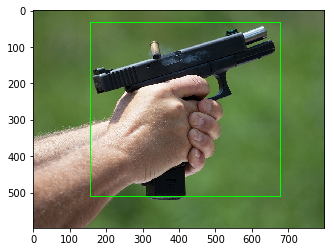

In [237]:
img = cv2.imread(store[1][0],1)
cv2.rectangle(img,(store[1][1], store[1][2]), (store[1][3], store[1][4]),(0,255,0),2)

plt.imshow(img[...,::-1])
plt.show()

**Data augmentation**

The mirrored version of the train images will be used to increase the number of instances available for training. Note that the coordinates (xmin, ymin) represent the top left corner of the bounding box. Similarly, the coordinates (xmax, ymax) represent the bottom right corner.

Notice what happens to these reference points as an image is mirrored.

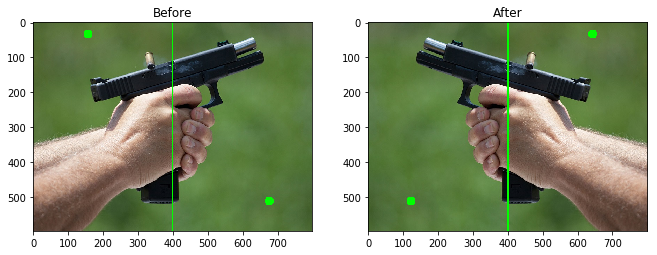

In [255]:
xmin, ymin, xmax, ymax  = np.array([store[1][1], store[1][2], store[1][3], store[1][4]]) # reference points
img = cv2.imread(store[1][0],1) # sample image

cv2.line(img,(xmin, ymin), (xmin, ymin),(0,255,0),25) # draw first point
cv2.line(img, (xmax, ymax), (xmax, ymax),(0,255,0),25) # draw second point

cx, cy = np.array(img.shape[:2])[::-1]/2 # image center point (x,y)
h, w = img.shape[:2] # image dimensions
cv2.line(img, (int(cx), 0), (int(cx), h),(0,255,0),2)

img2 =  img[:,::-1,:] # flip image horizontally
rcParams['figure.figsize'] = 11 ,8 # size

# plot
fig, ax = plt.subplots(1,2)
ax[0].title.set_text('Before')
ax[0].imshow(img[...,::-1]);

ax[1].title.set_text('After')
ax[1].imshow(img2[...,::-1]);

The coordinates (xmin, ymin) and (xmax, ymax) of the mirrored images need to follow a (top left) and (bottom right) format as well. Note that only the x-coordinates have to be modified in order to achieve this.

Find the new x-coordinates of the mirrored images.

In [239]:
def horFlip(img, xmin, xmax): # find new values for xmin and xmax
    
        cx, cy = np.array(img.shape[:2])[::-1]/2 # use image dimensions to find center point (x,y)
    
        """Step 1: Mirror xmin and xmax. 
        First, find the distance to the center. This distance is then multiplied by two. 
        The end goal is to shift to the opposite side. By adding this distance twice to 
        the initial value, we first make it to the center and then to the desired location."""
        
        xmin += 2*(cx.astype(np.int32) - (xmin).astype(np.int32)) 
        xmax += 2*(cx.astype(np.int32) - (xmax).astype(np.int32))
        
        """Step 2: Convert to top left and bottom right format.
        At this point, xmin and xmax have been mirrored but they are in the top right 
        and bottom left corner of the bounding box. To move them to the correct format 
        we calculate the width of the new bounding box and shift them respectively."""
        
        box_w = abs(xmin - xmax) # new bounding box width
        xmin -= box_w # shift xmin from top right to top left
        xmax += box_w # shift xmax from bottom left to bottom right
        
        return [xmin, xmax]

Capture relevant data for mirrored images.

In [240]:
mirrored = []

for k in range(len(store)): # for every train instance
    
    path = store[k][0] # path to image
    img = cv2.imread(store[k][0],1) # read image
    xmin, ymin, xmax, ymax = np.array([store[k][1], store[k][2], store[k][3], store[k][4]]) 
    
    xmin, xmax = horFlip(img, xmin, xmax) # find new xmin and xmax
    mirrored.append([path, xmin, ymin, xmax, ymax, 'gun'])
    
for instance in mirrored: # for every instance
    instance[0] = instance[0].replace('WeaponS', 'WeaponF') # update path to correct folder
    
store.extend(mirrored)
print("Gun | Additional Train Instances:", len(mirrored))

Gun | Additional Train Instances: 2786


Plot instance (and compare) to verify previous steps.

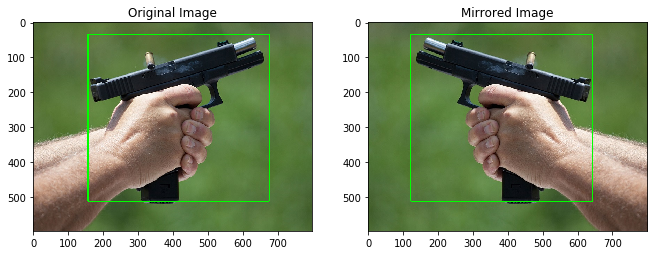

In [241]:
img = cv2.imread(store[1][0],1)
cv2.rectangle(img,(store[1][1], store[1][2]), (store[1][3], store[1][4]),(0,255,0),2)

img2 = cv2.imread(store[2787][0],1)
cv2.rectangle(img2,(store[2787][1], store[2787][2]), (store[2787][3], store[2787][4]),(0,255,0),2)

rcParams['figure.figsize'] = 11,8 # size

# plot
fig, ax = plt.subplots(1,2)
ax[0].title.set_text('Original Image')
ax[0].imshow(img[...,::-1]);

ax[1].title.set_text('Mirrored Image')
ax[1].imshow(img2[...,::-1]);

Save in RetinaNet format.

In [242]:
file = open(os.path.expanduser("~/Desktop/gunData.csv"),'w')

for rec in store:
    file.write(",".join(str(x) for x in rec)+'\n')
    
file.close()
print("Gun | Total Train Instances:", len(store))

Gun | Total Train Instances: 5572


## Knives
---

Store path for the images and annotations.

In [243]:
images_train = glob.glob(os.path.expanduser("~/Desktop/train2014/*.jpg"))
images_train = natsort.natsorted(images_train)
annFile =  os.path.expanduser("~/Desktop/annotations/instances_train2014.json")

Establish a holdout set (70/30).

In [244]:
images_test = glob.glob(os.path.expanduser("~/Desktop/val2014/*.jpg"))
images_test = natsort.natsorted(images_test)

print("Knife | Train Images:", len(images_train))
print("Knife | Test Images:", len(images_test))

Knife | Train Images: 3097
Knife | Test Images: 1410


**Prepare data for RetinaNet**

Each instance has to be captured in one row. If an image has multiple objects, it will be broken down into multiple instances. An image with two knives, for example, will become two records (one for each). The format we are looking for is the following: path, xmin, ymin, xmax, ymax, label.

In this context, xmin, ymin, xmax, and ymax define the bounding box around the object.

Parse annotation file.

In [245]:
store = [] # store for image ids
    
# for every train image
for image in images_train:
    store.append(image[-16:-4]) # store the filename (image id)

store_int = list(map(int,store)) # convert image ids to int

f =  open(annFile)
d = json.load(f) # load annotation file
f.close()

annotations = d['annotations'] # only interested in annotations
d = {}

for k in range(len(annotations)): # for every annotation

    img_id = annotations[k]['image_id']
    cat_id = annotations[k]['category_id'] # category 49 is for knife

    # if image id is found in training set and category is knife
    if img_id in store_int and cat_id == 49:

        if img_id in d: # if image id exists in dictionary
            d[img_id].append(annotations[k]['bbox']) # add bounding box

        else:
            d[img_id] = [] # add image id to dictionary
            d[img_id].append(annotations[k]['bbox']) # add bounding box 

Capture relevant data for train images.

In [246]:
output = [] # store for instances
ipath = os.path.expanduser(str("~/Desktop/train2014/COCO_train2014_")) # path to image (missing filename)

for k in range(len(store_int)): # for every train image

    N = len(d[store_int[k]]) # number of bounding boxes

    if N > 1: # if more than one bounding box

        for b in range(N): # for every bounding box

            file = ipath + store[k] + '.jpg' # full path
            bbox = d[store_int[k]][b] # bounding box values

            # decompose
            xmin = int(bbox[0])
            xmax = int(bbox[0] + bbox[2])
            ymax = int(bbox[1] + bbox[3])
            ymin = int(bbox[1])

            output.append([file, xmin, ymin, xmax, ymax, 'knife']) # push instance

    else:
        file = ipath + store[k] + '.jpg' # full path
        bbox = d[store_int[k]][0] # bounding box values

        # decompose
        xmin = int(bbox[0])
        xmax = int(bbox[0] + bbox[2])
        ymax = int(bbox[1] + bbox[3])
        ymin = int(bbox[1])

        output.append([file, xmin, ymin, xmax, ymax, 'knife']) # push instance

Plot instance to verify previous steps.

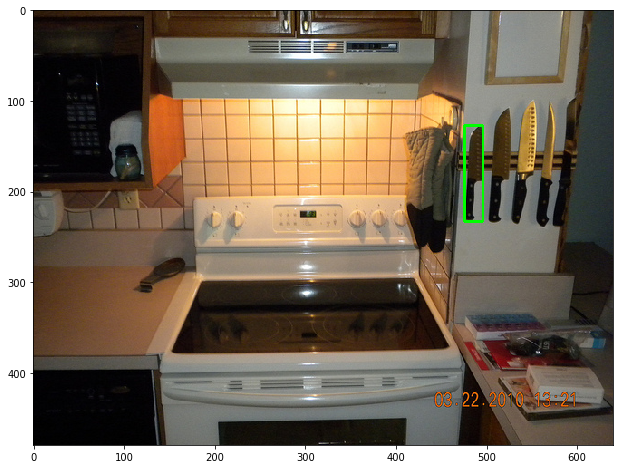

In [247]:
img = cv2.imread(output[1][0],1)
cv2.rectangle(img,(output[1][1], output[1][2]), (output[1][3], output[1][4]),(0,255,0),2)

plt.imshow(img[...,::-1])
plt.show()

Save in RetinaNet format.

In [248]:
file = open(os.path.expanduser("~/Desktop/knifeData.csv"),'w')

for rec in output:
    file.write(",".join(str(x) for x in rec)+'\n')
    
file.close()
print("Knife | Total Train Instances:", len(output))

Knife | Total Train Instances: 5536
